In [1]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from diffusers import utils
from diffusers import UNet2DConditionModel
from diffusers import AudioLDMPipeline
from diffusers import DDIMScheduler, PNDMScheduler
from typing import Any, Callable, Dict, List, Optional, Union

from torchvision.utils import save_image
import csv
import IPython.display as ipd

import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import argparse, os, sys, datetime, glob, importlib, csv
import math

import torchaudio
import torchaudio.transforms as transforms
import time
from encodec import EncodecModel
from encodec.utils import convert_audio
import torch.nn.functional as F
from transformers import AutoTokenizer, T5EncoderModel,T5TokenizerFast
from torchsummary import summary
from IPython.display import FileLink


In [2]:
channel_means = [  2.2741,  11.2872,  -3.3938,  -1.5556,  -0.0302,   7.6089,  -5.5797,
          0.2140,  -0.3536,   6.0188,   1.8582,  -0.1103,   2.2026,  -7.0081,
         -0.0721,  -8.7742,  -2.4182,   4.4447,  -0.2184,  -0.5209, -11.9494,
         -4.0776,  -1.4555,  -1.6505,   6.4522,   0.0997,  10.4067,  -3.9268,
         -7.0161,  -3.1253,  -8.5145,   3.1156,   2.2279,  -5.2728,   2.8541,
         -3.3980,  -1.1775,  -9.7662,   0.3048,   3.8765,   4.5021,   2.6239,
         14.1057,   3.2852,   1.9702,  -1.6345,  -4.3733,   3.8198,   1.1421,
         -4.4388,  -5.3498,  -6.6044,  -0.4426,   2.8000,  -7.0858,   2.4989,
         -1.4915,  -6.1275,  -3.0896,   1.1227,  -8.7984,  -4.9831,  -0.3888,
         -3.1017,  -7.5745,  -2.4760,   1.0540,  -2.5350,   0.0999,   0.6126,
         -1.2301,  -5.8328,  -0.7275,  -1.2316,  -2.2532, -11.5017,   0.9166,
         -2.2268,  -2.8496,  -0.5093,  -0.3037,  -6.3689,  -9.5225,   4.5965,
          3.1329,  -1.8315,   5.3135,  -3.8361,   1.6335,  -0.1705,  11.0513,
          5.3907,  -0.2660,   4.6109,  -8.9019,   6.5515,   0.8596,  16.6196,
         -0.7732,   4.1237,   2.9267,   9.9652,   4.6615,   1.4660,  -9.7225,
         -1.5841,  -0.5714,  -4.3343,  -0.1914,   2.8624, -11.2139,  -2.5840,
         -6.7120,   0.2601,  -5.4195,   0.3554,   3.0438,  -1.0295,   1.3360,
         -4.1767,   0.6468,   1.8145,   1.7140,   3.0185,   0.4881,   0.5796,
         -2.4755,   2.6202]
channel_stds = [1.7524, 1.2040, 1.1098, 1.1021, 1.3688, 1.1374, 1.8660, 0.9791, 1.4331,
        1.7740, 1.2690, 1.0297, 0.9953, 1.5363, 1.2166, 1.6564, 1.4858, 1.2349,
        1.5086, 1.0814, 1.4421, 0.9258, 0.9343, 1.2007, 1.3848, 1.2732, 1.7759,
        1.3544, 1.4707, 1.2685, 1.7004, 1.2947, 1.2967, 1.8925, 0.9231, 0.7637,
        1.3777, 1.6680, 0.9658, 0.9257, 0.5259, 0.9949, 1.7375, 1.0734, 1.2916,
        0.8570, 0.6263, 0.9911, 0.9574, 0.9979, 1.5969, 1.1886, 1.1147, 1.2280,
        2.0169, 1.1813, 1.2589, 1.1162, 1.3689, 1.2516, 1.2139, 1.0343, 1.1895,
        1.1726, 1.1923, 1.2714, 1.0043, 0.6465, 1.3860, 1.4449, 0.9567, 1.0218,
        0.9560, 1.4757, 1.0544, 0.8112, 1.4364, 1.0843, 1.2569, 1.0138, 1.1886,
        0.8627, 1.1016, 1.4231, 1.3607, 1.1215, 1.9759, 1.5381, 0.9219, 0.8572,
        0.6288, 0.8029, 1.1699, 1.1962, 1.5783, 0.9037, 1.2214, 2.0878, 1.3015,
        1.2254, 1.2898, 1.5421, 1.2834, 1.7237, 1.3471, 0.8689, 1.2807, 1.2174,
        1.2048, 0.6644, 1.5379, 1.4997, 0.7932, 0.7638, 0.8680, 1.3108, 1.8261,
        1.3964, 1.2147, 1.1391, 1.0011, 1.5988, 1.5721, 1.0963, 1.4303, 1.3737,
        1.5043, 1.3079]

In [3]:

def rescale(image):
    image = torch.Tensor.view(image, [128, 24, 21]).clone()
    mean_v = torch.tensor(channel_means)
    std_v =torch.tensor(channel_stds)
    image = image * std_v.view(-1,1,1) + mean_v.view(-1,1,1)
    image = torch.Tensor.view(image, [1, 128, 504])
    return image

model_path = "CompVis/stable-diffusion-v1-4"
device = "cuda"

torch.set_grad_enabled(False) 

In [91]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    device_map=None, 
    safety_checker=None,
    low_cpu_mem_usage=False)

pipe.to(device)
pipe.vae_scale_factor = 1

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [92]:

tokenizer = AutoTokenizer.from_pretrained("t5-large", model_max_length=512)
text_encoder = T5EncoderModel.from_pretrained("t5-large")
text_encoder.config.use_attention_mask = False
pipe.tokenizer = tokenizer
pipe.text_encoder = text_encoder.to(device)


Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.14.layer.2.layer_norm.weight', 'decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.6.layer.1.EncDecAttention.k.weight', 'decoder.block.17.layer.2.DenseReluDense.wo.weight', 'decoder.block.6.layer.0.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.13.layer.1.layer_norm.weight', 'decoder.block.17.layer.0.SelfAttention.k.weight', 'decoder.block.16.layer.1.EncDecAttention.k.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.9.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.2.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.12.layer.2.DenseReluDense.wi.weight', 'decoder.block.16.layer.2.layer_norm.weight', 'decoder.block.15.layer.0.layer_norm.weight', 'decoder.block.18.layer.0.SelfAttention.o.weight', 'decoder.block.21.layer.0.SelfAttention.o.weight', 'decoder.block.11.l

In [93]:

enc_model = EncodecModel.encodec_model_24khz()
enc_model.set_target_bandwidth(6.0)
enc_model = enc_model.to(device)
# pipe.vae = model


In [94]:
unet_path = #path to trained unet folder
new_unet = UNet2DConditionModel.from_pretrained(unet_path)
new_unet.to(device)
pipe.unet = new_unet

In [95]:
prompts = [
    "sound of a dog barking",
          ]

In [96]:
def rescale_encodec_batch(latents, device):
    latents = torch.Tensor.view(latents, [latents.shape[0], 128, 24, 21]).clone().to(device)

    mean_v = torch.tensor(channel_means).to(device).view(1, 128, 1, 1)

    std_v =torch.tensor(channel_stds).to(device).view(1, 128, 1, 1)

    latents = latents * std_v + mean_v

    latents = latents.view([latents.shape[0], 1, 128, 504])
    return latents

In [97]:
def encode_prompt(
        pipe,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        lora_scale: Optional[float] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
             prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            lora_scale (`float`, *optional*):
                A lora scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
        """

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:

            text_inputs = pipe.tokenizer(
                prompt,
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = pipe.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = pipe.tokenizer.batch_decode(
                    untruncated_ids[:, pipe.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {pipe.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            prompt_embeds = pipe.text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            prompt_embeds = prompt_embeds[0]

        prompt_embeds = prompt_embeds.to(dtype=pipe.text_encoder.dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size

            elif prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = prompt_embeds.shape[1]
            uncond_input = pipe.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask:
                uncond_attention_mask = uncond_input.attention_mask.to(device)
            else:
                uncond_attention_mask = None

            negative_prompt_embeds = pipe.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=uncond_attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=pipe.text_encoder.dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
            
        return prompt_embeds, attention_mask
        
        # return prompt_embeds

In [98]:
def sample(
    pipe,
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
    latents: Optional[torch.FloatTensor] = None,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
    callback_steps: int = 1,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    unet_mask = False,
    debug = False,
    class_labels=None,
    guidance_rescale: float = 0.0,
):
    r"""
    Function invoked when calling the pipeline for generation.

    Args:
        prompt (`str` or `List[str]`, *optional*):
            The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
            instead.
        height (`int`, *optional*, defaults to pipe.unet.config.sample_size * pipe.vae_scale_factor):
            The height in pixels of the generated image.
        width (`int`, *optional*, defaults to pipe.unet.config.sample_size * pipe.vae_scale_factor):
            The width in pixels of the generated image.
        num_inference_steps (`int`, *optional*, defaults to 50):
            The number of denoising steps. More denoising steps usually lead to a higher quality image at the
            expense of slower inference.
        guidance_scale (`float`, *optional*, defaults to 7.5):
            Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
            `guidance_scale` is defined as `w` of equation 2. of [Imagen
            Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
            1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
            usually at the expense of lower image quality.
        negative_prompt (`str` or `List[str]`, *optional*):
            The prompt or prompts not to guide the image generation. If not defined, one has to pass
            `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
            less than `1`).
        num_images_per_prompt (`int`, *optional*, defaults to 1):
            The number of images to generate per prompt.
        eta (`float`, *optional*, defaults to 0.0):
            Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
            [`schedulers.DDIMScheduler`], will be ignored for others.
        generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
            One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
            to make generation deterministic.
        latents (`torch.FloatTensor`, *optional*):
            Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
            generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
            tensor will ge generated by sampling using the supplied random `generator`.
        prompt_embeds (`torch.FloatTensor`, *optional*):
            Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
            provided, text embeddings will be generated from `prompt` input argument.
        negative_prompt_embeds (`torch.FloatTensor`, *optional*):
            Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
            weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
            argument.
        output_type (`str`, *optional*, defaults to `"pil"`):
            The output format of the generate image. Choose between
            [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
        return_dict (`bool`, *optional*, defaults to `True`):
            Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
            plain tuple.
        callback (`Callable`, *optional*):
            A function that will be called every `callback_steps` steps during inference. The function will be
            called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
        callback_steps (`int`, *optional*, defaults to 1):
            The frequency at which the `callback` function will be called. If not specified, the callback will be
            called at every step.
        cross_attention_kwargs (`dict`, *optional*):
            A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
            `pipe.processor` in
            [diffusers.cross_attention](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/cross_attention.py).
        guidance_rescale (`float`, *optional*, defaults to 0.7):
            Guidance rescale factor proposed by [Common Diffusion Noise Schedules and Sample Steps are
            Flawed](https://arxiv.org/pdf/2305.08891.pdf) `guidance_scale` is defined as `φ` in equation 16. of
            [Common Diffusion Noise Schedules and Sample Steps are Flawed](https://arxiv.org/pdf/2305.08891.pdf).
            Guidance rescale factor should fix overexposure when using zero terminal SNR.

    Examples:

    Returns:
    """
    # 0. Default height and width to unet
    height = height or pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = width or pipe.unet.config.sample_size * pipe.vae_scale_factor

    # 1. Check inputs. Raise error if not correct
    pipe.check_inputs(
        prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
    )

    # 2. Define call parameters
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    device = pipe._execution_device
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt

    text_encoder_lora_scale = (
        cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
    )
    prompt_embeds, attn_mask = encode_prompt(
        pipe,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        lora_scale=text_encoder_lora_scale,
    )
    if debug:
        print(f'Attention Mask :{attention_mask}')
    # 4. Prepare timesteps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps

    # 5. Prepare latent variables
    # num_channels_latents = pipe.unet.config.in_channels
    num_channels_latents = 1
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
        latents,
    )
    
    # targ_height, targ_width = self.closest_factors(sample.shape[-1])
    # orig_shape = sample.shape[-1]
    # new_shape = [sample.shape[0], 128, 24, 21]
    


    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    base_shape = None
    new_shape = None
    # 7. Denoising loop
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
            if new_shape is None:
                new_shape = [latent_model_input.shape[0], 128, 24, 21]
                base_shape = latent_model_input.shape
                
            latent_model_input = torch.Tensor.view(latent_model_input, new_shape)

            # predict the noise residual
            if unet_mask:
                if debug:
                    print(f'unet getting attention mask:{attention_mask}')
                noise_pred = pipe.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    class_labels=class_labels,
                ).sample
            else:
                if debug:
                    print(f'unet Cross Attention UNMASKED!')
                noise_pred = pipe.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    class_labels=class_labels,
                ).sample
            noise_pred = torch.Tensor.view(noise_pred, base_shape)
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            noise_pred_peek = torch.Tensor.view(noise_pred.clone(), [latents.shape[0], 128, 24, 21])

            for img in noise_pred_peek:
                means = img.mean(axis=(1,2))
                stds = img.std(axis=(1,2))
                if debug:
                    print(f'Noise Mean: {means}')
                    print(f'Noise std:  {stds}')
                # print(f'MEAN: mean {means.mean()} -- std {means.std()}')
                # print(f'STD: mean {stds.mean()} -- std {stds.std()}')
                    print()
            # compute the previous noisy sample x_t -> x_t-1
            latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()
                if callback is not None and i % callback_steps == 0:
                    callback(i, t, latents)

    latents = rescale_encodec_batch(latents, pipe.device)
    
    return enc_model.decoder(latents[:, 0, :, :])

In [99]:
imgs = [sample(pipe, prompt=p, width=504, height=128, num_inference_steps=50, guidance_scale=6.5, output_type="latent", unet_mask=False, debug=False) for p in prompts]


  0%|          | 0/50 [00:00<?, ?it/s]

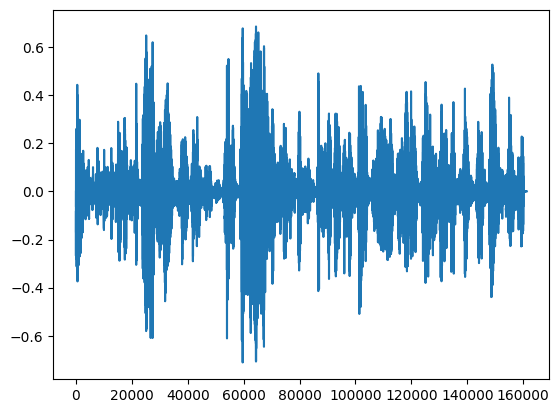

In [100]:
imgs[0].shape
waveform = imgs[0][0,0].cpu().detach().numpy()
plt.plot(waveform)
ipd.Audio(waveform, rate=16_000)